# ML3 - Hackathon

## Metric to measure:

## Data Description:

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm

from matplotlib import pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import silhouette_score, silhouette_samples, make_scorer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('ML3 data.csv')
df.head()

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
0,73557,8,2,1,69,NaN,4,4,1,NaN,...,1.470207,4.864849,3.636711,-9.174492,-9.353410,5.153847,1.294983,-1.015693,-8.671692,5.423061
1,73558,8,2,1,54,NaN,3,3,1,NaN,...,-7.363791,-2.566326,0.776046,-2.951925,-0.538597,3.770290,6.711471,3.521875,-1.765809,-5.383746
2,73559,8,2,1,72,NaN,3,3,2,NaN,...,-7.187977,-9.730452,9.906254,7.636725,-7.642553,7.356881,-9.626078,3.871285,-1.673816,-3.973037
3,73560,8,2,1,9,NaN,3,3,1,119.0,...,-7.164299,-8.283262,0.184733,1.245878,-9.309774,1.965447,-8.320304,-6.444928,-4.297771,1.870141
4,73561,8,2,2,73,NaN,3,3,1,NaN,...,0.127513,-8.721841,0.013319,3.599418,9.263045,4.388852,6.608509,-6.813265,-9.492588,-0.342957


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 662 entries, SEQN to ar25
dtypes: float64(641), int64(21)
memory usage: 49.6 MB


In [4]:
valid = (df.isnull().sum() / len(df)) < .6

In [5]:
valid_columns = valid[valid == True].index
valid_columns

Index(['SEQN', 'SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1',
       'RIDRETH3', 'RIDEXMON', 'RIDEXAGM', 'DMQMILIZ',
       ...
       'ar16', 'ar17', 'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24',
       'ar25'],
      dtype='object', length=331)

In [7]:
invalid_columns = valid[valid == False].index
invalid_columns

Index(['RIDAGEMN', 'DMQADFC', 'DMDYRSUS', 'DMDEDUC3', 'RIDEXPRG', 'DR1SKY',
       'DRQSDT1', 'DRQSDT2', 'DRQSDT3', 'DRQSDT4',
       ...
       'URXUSR', 'URDUSRLC', 'URXUTL', 'URDUTLLC', 'URXUTU', 'URDUTULC',
       'URXUUR', 'URDUURLC', 'URXPREG', 'URXUAS'],
      dtype='object', length=331)

In [8]:
len(valid_columns) + len(invalid_columns) == len(df.columns)

True

In [9]:
set_valid = set(valid_columns)
set_invalid = set(invalid_columns)
print(len(set_valid) + len(set_invalid) == len(df.columns))
set_valid.intersection(set_invalid)

True


set()

In [10]:
df_valid = df.loc[:, valid_columns]
df_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 331 entries, SEQN to ar25
dtypes: float64(310), int64(21)
memory usage: 24.8 MB


In [11]:
is_null = df_valid.isnull().sum()
is_null

SEQN        0
SDDSRVYR    0
RIDSTATR    0
RIAGENDR    0
RIDAGEYR    0
           ..
ar21        0
ar22        0
ar23        0
ar24        0
ar25        0
Length: 331, dtype: int64

In [12]:
df_valid.shape

(9813, 331)

In [15]:
uniqueness = df_valid.nunique() == len(df_valid)
all_unique = uniqueness[uniqueness == True].index
print(all_unique)

Index(['SEQN', 'ar1', 'ar2', 'ar3', 'ar4', 'ar5', 'ar6', 'ar7', 'ar8', 'ar9',
       'ar10', 'ar11', 'ar12', 'ar13', 'ar14', 'ar15', 'ar16', 'ar17', 'ar18',
       'ar19', 'ar20', 'ar21', 'ar22', 'ar23'],
      dtype='object')


In [16]:
df_valid.drop(['SEQN'], axis=1, inplace=True)

In [17]:
has_null_columns = (is_null[is_null > 0] / len(df_valid)).index
has_null_columns

Index(['RIDEXAGM', 'DMQMILIZ', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'SIAPROXY',
       'FIALANG', 'FIAPROXY', 'FIAINTRP', 'MIALANG',
       ...
       'LBDBSESI', 'LBDBSELC', 'LBXBMN', 'LBDBMNSI', 'LBDBMNLC', 'URXUTRI',
       'URXVOL1', 'URDFLOW1', 'LBDB12', 'LBDB12SI'],
      dtype='object', length=282)

In [18]:
length = len(df_valid)
for col in has_null_columns:
    print("Column %s: isnull = %s, unique = %s" %(
        col, (df_valid[col].isnull().sum()/length)*100, df_valid[col].nunique())
    )
    

Column RIDEXAGM: isnull = 57.0671558137165, unique = 240
Column DMQMILIZ: isnull = 38.18404157749924, unique = 3
Column DMDCITZN: isnull = 0.040762254152654644, unique = 4
Column DMDEDUC2: isnull = 43.055130948741464, unique = 7
Column DMDMARTL: isnull = 43.055130948741464, unique = 8
Column SIAPROXY: isnull = 0.010190563538163661, unique = 2
Column FIALANG: isnull = 1.0292469173545296, unique = 2
Column FIAPROXY: isnull = 1.0292469173545296, unique = 2
Column FIAINTRP: isnull = 1.0292469173545296, unique = 2
Column MIALANG: isnull = 25.49678997248548, unique = 2
Column MIAPROXY: isnull = 25.486599408947313, unique = 2
Column MIAINTRP: isnull = 25.47640884540915, unique = 2
Column AIALANGA: isnull = 35.62621012942016, unique = 3
Column DMDHRBR4: isnull = 2.70049933761337, unique = 3
Column DMDHREDU: isnull = 2.6699276469988793, unique = 7
Column DMDHRMAR: isnull = 1.14134311627433, unique = 8
Column DMDHSEDU: isnull = 47.03964129216346, unique = 7
Column INDHHIN2: isnull = 1.1515336798

In [19]:
is_cat_column = df_valid.nunique() <= 16
is_cat_column

SDDSRVYR     True
RIDSTATR     True
RIAGENDR     True
RIDAGEYR    False
RIDRETH1     True
            ...  
ar21        False
ar22        False
ar23        False
ar24        False
ar25        False
Length: 330, dtype: bool

In [20]:
cat_columns = is_cat_column[is_cat_column == True].index
cat_columns

Index(['SDDSRVYR', 'RIDSTATR', 'RIAGENDR', 'RIDRETH1', 'RIDRETH3', 'RIDEXMON',
       'DMQMILIZ', 'DMDBORN4', 'DMDCITZN', 'DMDEDUC2',
       ...
       'LBDIHGLC', 'LBDBGELC', 'LBDBGMLC', 'LBXTTG', 'LBDBPBLC', 'LBDBCDLC',
       'LBDTHGLC', 'LBDBSELC', 'LBDBMNLC', 'URXUTRI'],
      dtype='object', length=138)

In [21]:
num_columns = is_cat_column[is_cat_column == False].index
num_columns

Index(['RIDAGEYR', 'RIDEXAGM', 'DMDHRAGE', 'WTINT2YR', 'WTMEC2YR', 'INDFMPIR',
       'WTDRD1', 'WTDR2D', 'DR1DBIH', 'DR1TNUMF',
       ...
       'ar16', 'ar17', 'ar18', 'ar19', 'ar20', 'ar21', 'ar22', 'ar23', 'ar24',
       'ar25'],
      dtype='object', length=192)

In [22]:
df_valid[num_columns].median()

RIDAGEYR       27.000000
RIDEXAGM      103.000000
DMDHRAGE       43.000000
WTINT2YR    20249.482420
WTMEC2YR    20965.111880
                ...     
ar21            1.884456
ar22            0.814447
ar23           -0.763828
ar24           -4.263325
ar25            1.885457
Length: 192, dtype: float64

In [23]:
df_valid[num_columns] = df_valid[num_columns].fillna(df_valid[num_columns].median())

In [24]:
df_valid[cat_columns].mode()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,DMDCITZN,DMDEDUC2,...,LBDIHGLC,LBDBGELC,LBDBGMLC,LBXTTG,LBDBPBLC,LBDBCDLC,LBDTHGLC,LBDBSELC,LBDBMNLC,URXUTRI
0,8,2,2,3,3,2,2.0,1,1.0,4.0,...,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0


In [25]:
df_valid[cat_columns] = df_valid[cat_columns].fillna(df_valid[cat_columns].mode().iloc[0])

In [26]:
is_null = df_valid.isnull().sum()

In [27]:
has_null_columns = (is_null[is_null > 0] / len(df_valid)).index
has_null_columns

Index([], dtype='object')

In [28]:
length = len(df_valid)
for col in has_null_columns:
    print("Column %s: isnull = %s, unique = %s" %(col, (df_valid[col].isnull().sum()/length)*100, df_valid[col].nunique()))

In [29]:
df_valid.describe()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,DMDBORN4,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
count,9813.0,9813.0,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,...,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000,9813.000000
mean,8.0,2.0,1.507694,31.629573,3.083766,3.277897,1.508509,104.922756,1.947213,1.219709,...,-1.868362,-3.024976,0.103960,1.732914,-2.639643,0.516211,0.847771,0.436837,-2.754273,2.018194
std,0.0,0.0,0.499966,24.397553,1.262812,1.607957,0.499953,45.769261,0.230355,1.579601,...,5.689419,5.572118,5.621485,4.612798,7.025533,5.099966,7.074776,5.891879,5.608956,4.114095
min,8.0,2.0,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,-9.932773,-9.742275,-9.504686,-9.936065,-9.915099,-9.905405,-9.646950,-9.329935,-9.574369,-9.877965
25%,8.0,2.0,1.000000,10.000000,2.000000,2.000000,1.000000,103.000000,2.000000,1.000000,...,-7.164033,-8.291340,-6.029267,-1.014871,-9.200133,-2.849344,-8.087627,-6.434927,-7.405031,-0.326282
50%,8.0,2.0,2.000000,27.000000,3.000000,3.000000,2.000000,103.000000,2.000000,1.000000,...,-3.237602,-4.672666,0.173614,1.830624,-5.338621,1.884456,0.814447,-0.763828,-4.263325,1.885457
75%,8.0,2.0,2.000000,52.000000,4.000000,4.000000,2.000000,103.000000,2.000000,1.000000,...,1.883083,2.533461,5.417423,4.025792,1.521804,5.003854,8.079576,7.174353,1.071647,4.904403
max,8.0,2.0,2.000000,80.000000,5.000000,7.000000,2.000000,239.000000,7.000000,77.000000,...,9.984094,10.010548,9.933308,9.580645,9.837051,9.202594,9.679657,8.967017,9.944636,8.362119


In [30]:
df_num = df_valid[num_columns]
df_cat = df_valid[cat_columns]
df_num.head()

,RIDAGEYR,RIDEXAGM,DMDHRAGE,WTINT2YR,WTMEC2YR,INDFMPIR,WTDRD1,WTDR2D,DR1DBIH,DR1TNUMF,...,ar16,ar17,ar18,ar19,ar20,ar21,ar22,ar23,ar24,ar25
0,69,103.0,69,13281.23739,13481.04209,0.84,16888.32786,12930.89065,6.0,11.0,...,1.470207,4.864849,3.636711,-9.174492,-9.353410,5.153847,1.294983,-1.015693,-8.671692,5.423061
1,54,103.0,54,23682.05739,24471.76963,1.78,17932.14387,12684.14887,4.0,8.0,...,-7.363791,-2.566326,0.776046,-2.951925,-0.538597,3.770290,6.711471,3.521875,-1.765809,-5.383746
2,72,103.0,72,57214.80332,57193.28538,4.51,59641.81293,39394.23671,18.0,27.0,...,-7.187977,-9.730452,9.906254,7.636725,-7.642553,7.356881,-9.626078,3.871285,-1.673816,-3.973037
3,9,119.0,33,55201.17859,55766.51244,2.52,142203.06990,125966.36640,21.0,19.0,...,-7.164299,-8.283262,0.184733,1.245878,-9.309774,1.965447,-8.320304,-6.444928,-4.297771,1.870141
4,73,103.0,78,63709.66707,65541.87123,5.00,59052.35703,39004.89299,18.0,7.0,...,0.127513,-8.721841,0.013319,3.599418,9.263045,4.388852,6.608509,-6.813265,-9.492588,-0.342957


In [31]:
df_cat.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,DMDCITZN,DMDEDUC2,...,LBDIHGLC,LBDBGELC,LBDBGMLC,LBXTTG,LBDBPBLC,LBDBCDLC,LBDTHGLC,LBDBSELC,LBDBMNLC,URXUTRI
0,8,2,1,4,4,1,1.0,1,1.0,3.0,...,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
1,8,2,1,3,3,1,2.0,1,1.0,3.0,...,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
2,8,2,1,3,3,2,1.0,1,1.0,4.0,...,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0
3,8,2,1,3,3,1,2.0,1,1.0,4.0,...,0.0,1.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,2.0
4,8,2,2,3,3,1,2.0,1,1.0,5.0,...,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0


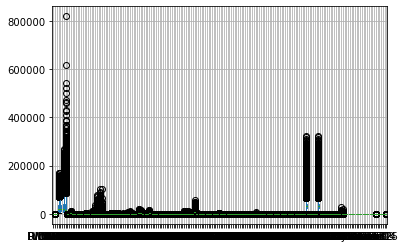

In [33]:
df_num.boxplot()
plt.show()

In [34]:
q_25 = df_num.quantile(0.25)
q_75 = df_num.quantile(0.75)

iqr = q_75 - q_25
ll = q_25 - 1.5 * iqr
ul = q_75 + 1.5 * iqr

for col in df_num.columns:
    val = np.where(df_num[col] > ul[col], ul[col], df_num[col])
    df_num[col]= val

for col in df_num.columns:
    val = np.where(df_num[col] < ll[col], ll[col], df_num[col])
    df_num[col] = val

/var/folders/8n/4hdxhx_s7rs_j79h2737dk_00000gn/T/ipykernel_5790/3480345743.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col]= val
/var/folders/8n/4hdxhx_s7rs_j79h2737dk_00000gn/T/ipykernel_5790/3480345743.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num[col] = val


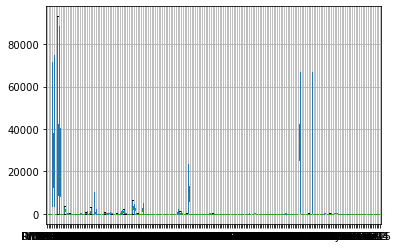

In [35]:
df_num.boxplot()
plt.show()

In [36]:
def run_vif(inp_df, cutt_off=5):
    condition = True
    vif_df = pd.DataFrame(
        {
            'Feature': [],
            'vif': [],
        }
    )

    while condition:
        vif_df.drop(vif_df.index, inplace=True)
    #     print(vif_df)
        X = inp_df.drop(G_DROP_COLUMNS, axis=1)
        columns = X.columns.to_list()
        values = X.values
        vifs = []
        for i in range(len(columns)):
            adf = pd.DataFrame(
                {
                    'Feature': columns[i],
                    'vif': variance_inflation_factor(values, i)
                },
                index=[0]
            )
            vif_df = pd.concat([vif_df, adf], ignore_index=True)

        vif_df.sort_values(by='vif', inplace=True, ascending=False)
        vif_df.reset_index(inplace=True, drop=True)
    #     print(vif_df)
        if vif_df.loc[0].vif >= cutt_off:
            print(
                "For Feature :",
                vif_df.loc[0].Feature,
                ". The vif is = ",
                vif_df.loc[0].vif,
                ". which is greater than %s so dropping" % (cutt_off)
            )
            inp_df.drop([vif_df.loc[0].Feature], axis=1, inplace=True)
        else:
            condition = False

    print(vif_df)
    
    return inp_df

In [37]:
G_DROP_COLUMNS = []
df_num_1 = run_vif(df_num.copy())

/Users/midhuncnair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/midhuncnair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/midhuncnair/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


For Feature : LBDSALSI . The vif is =  inf . which is greater than 5 so dropping
For Feature : LBDSGBSI . The vif is =  inf . which is greater than 5 so dropping
For Feature : URXUMS . The vif is =  inf . which is greater than 5 so dropping
For Feature : WTSH2YR.x . The vif is =  inf . which is greater than 5 so dropping
For Feature : LBXSCA . The vif is =  inf . which is greater than 5 so dropping
For Feature : URXCRS . The vif is =  inf . which is greater than 5 so dropping
For Feature : LBDSTPSI . The vif is =  inf . which is greater than 5 so dropping
For Feature : LBDSTBSI . The vif is =  1119173255.8847854 . which is greater than 5 so dropping
For Feature : LBXBMN . The vif is =  103576561.50649992 . which is greater than 5 so dropping
For Feature : LBDSCRSI . The vif is =  20475474.35862397 . which is greater than 5 so dropping
For Feature : LBDSTRSI . The vif is =  4698227.904432682 . which is greater than 5 so dropping
For Feature : LBXSUA . The vif is =  4247417.370716673 . w

In [38]:
len(df_num_1.columns), len(df_num.columns)

(118, 192)

In [39]:
df_pv = pd.concat([df_cat, df_num_1], axis=1)
df_pv.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDRETH1,RIDRETH3,RIDEXMON,DMQMILIZ,DMDBORN4,DMDCITZN,DMDEDUC2,...,ar12,ar14,ar15,ar16,ar17,ar18,ar19,ar20,ar24,ar25
0,8,2,1,4,4,1,1.0,1,1.0,3.0,...,7.647778,6.290283,8.513808,1.470207,4.864849,3.636711,-8.575865,-9.353410,-8.671692,5.423061
1,8,2,1,3,3,1,2.0,1,1.0,3.0,...,1.920454,-5.967698,6.976290,-7.363791,-2.566326,0.776046,-2.951925,-0.538597,-1.765809,-5.383746
2,8,2,1,3,3,2,1.0,1,1.0,4.0,...,-9.672160,3.075459,9.430867,-7.187977,-9.730452,9.906254,7.636725,-7.642553,-1.673816,-3.973037
3,8,2,1,3,3,1,2.0,1,1.0,4.0,...,7.705442,9.971084,-1.796561,-7.164299,-8.283262,0.184733,1.245878,-9.309774,-4.297771,1.870141
4,8,2,2,3,3,1,2.0,1,1.0,5.0,...,-5.575511,-7.632324,7.456335,0.127513,-8.721841,0.013319,3.599418,9.263045,-9.492588,-0.342957


In [40]:
pca = PCA()
pca.fit(df_pv)

PCA()

In [41]:
pca.explained_variance_ratio_

array([7.28263007e-01, 1.41373669e-01, 7.87434194e-02, 4.38439661e-02,
       5.56509660e-03, 1.01030178e-03, 5.12263572e-04, 3.48873122e-04,
       9.83369089e-05, 8.54801583e-05, 7.91952776e-05, 3.32930474e-05,
       1.64000386e-05, 3.83009137e-06, 2.58261141e-06, 2.44544657e-06,
       2.35229700e-06, 2.18654703e-06, 1.88661062e-06, 1.76362406e-06,
       1.43200932e-06, 1.40830274e-06, 1.20665291e-06, 9.01377945e-07,
       8.67283810e-07, 6.72797391e-07, 6.39171133e-07, 4.31534056e-07,
       3.13799481e-07, 2.81085139e-07, 1.79932044e-07, 1.72223284e-07,
       1.58163593e-07, 1.29973969e-07, 1.20388055e-07, 9.00453164e-08,
       6.71814059e-08, 6.36682247e-08, 4.96997073e-08, 4.87998127e-08,
       3.84115654e-08, 3.64865032e-08, 3.47092830e-08, 3.01376424e-08,
       2.23561552e-08, 1.80466680e-08, 1.80041916e-08, 1.69929001e-08,
       1.56033628e-08, 1.45353792e-08, 1.30064562e-08, 1.14679933e-08,
       1.08807393e-08, 1.00351498e-08, 9.36156035e-09, 8.11054896e-09,
      

In [42]:
sum(pca.explained_variance_ratio_)

1.0

In [43]:
c_sum = 0
for i, it in enumerate(pca.explained_variance_ratio_):
    c_sum += it
    print("for i = %s sum = %s" % (i+1, c_sum * 100))
    if c_sum >= .9997:
        break

for i = 1 sum = 72.82630070314298
for i = 2 sum = 86.96366763532039
for i = 3 sum = 94.83800957219606
for i = 4 sum = 99.22240618539145
for i = 5 sum = 99.77891584569134
for i = 6 sum = 99.87994602411825
for i = 7 sum = 99.93117238136577
for i = 8 sum = 99.96605969352646
for i = 9 sum = 99.97589338441692


In [46]:
component = 4

In [47]:
pca = PCA(n_components=component)
pca.fit(df_pv)
pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

(array([0.72826301, 0.14137367, 0.07874342, 0.04384397]), 0.9922240618539148)

In [48]:
df_pca = pd.DataFrame(pca.transform(df_pv), columns=['PCA%s'%(i + 1) for i in range(component)])
df_pca

,PCA1,PCA2,PCA3,PCA4
0,-23062.932401,-1762.589067,-1974.164673,-6853.423548
1,-14176.772527,-16210.573668,-8621.959899,-4422.553739
2,47100.090905,-26443.831666,-2825.981860,-3092.737666
3,93209.020877,11804.126458,-1603.276295,-10618.181750
4,40940.255660,-8242.914770,19956.239333,12548.357265
...,...,...,...,...
9808,-20147.822130,-9322.625708,971.861722,4623.891295
9809,9961.070305,32661.052175,2851.951034,-4808.356349
9810,-14730.474736,-23489.485641,-14498.803915,-5963.501745
9811,-27504.921351,1080.788684,-5800.093322,14865.168949


In [49]:
df_pca_init = df_pca

In [75]:
scaler = StandardScaler()
scaler.fit(df_pca_init)
df_pca = scaler.transform(df_pca_init)
df_pca = pd.DataFrame(df_pca, columns=['PCA%s'%(i + 1) for i in range(component)])
df_pca

,PCA1,PCA2,PCA3,PCA4
0,-0.577322,-0.100142,-0.150288,-0.699199
1,-0.354880,-0.921005,-0.656367,-0.451197
2,1.179032,-1.502409,-0.215135,-0.315527
3,2.333253,0.670653,-0.122053,-1.083286
4,1.024836,-0.468322,1.519216,1.280206
...,...,...,...,...
9808,-0.504350,-0.529666,0.073985,0.471738
9809,0.249350,1.855641,0.217112,-0.490557
9810,-0.368740,-1.334557,-1.103756,-0.608407
9811,-0.688516,0.061405,-0.441546,1.516572


In [69]:
df_pca_init.head()

,PCA1,PCA2,PCA3,PCA4
0,-23062.932401,-1762.589067,-1974.164673,-6853.423548
1,-14176.772527,-16210.573668,-8621.959899,-4422.553739
2,47100.090905,-26443.831666,-2825.981860,-3092.737666
3,93209.020877,11804.126458,-1603.276295,-10618.181750
4,40940.255660,-8242.914770,19956.239333,12548.357265


In [51]:
wcss  = []

# use for loop to perform K-means with different values of K
# set the 'random_state' to obtain the same centroid initialization for each code run
# fit the model on scaled data
# append the value of WCSS for each K to the list 'wcss'
# the 'inertia_' retuns the WCSS for specific value of K
for i in range(1,21):
    kmeans = KMeans(n_clusters = i, random_state = 10)
    kmeans.fit(df_pca)
    wcss.append(kmeans.inertia_)

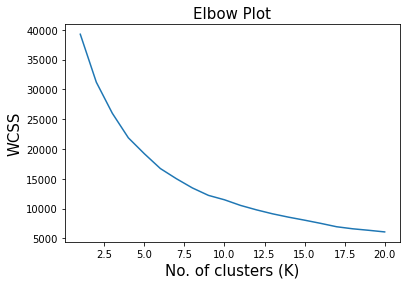

In [52]:
# visualize the elbow plot to get the optimal value of K
plt.plot(range(1,21), wcss)

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Elbow Plot', fontsize = 15)
plt.xlabel('No. of clusters (K)', fontsize = 15)
plt.ylabel('WCSS', fontsize = 15)

# display the plot
plt.show()

In [53]:
X = df_pca

In [54]:
X

,PCA1,PCA2,PCA3,PCA4
0,-0.577322,-0.100142,-0.150288,-0.699199
1,-0.354880,-0.921005,-0.656367,-0.451197
2,1.179032,-1.502409,-0.215135,-0.315527
3,2.333253,0.670653,-0.122053,-1.083286
4,1.024836,-0.468322,1.519216,1.280206
...,...,...,...,...
9808,-0.504350,-0.529666,0.073985,0.471738
9809,0.249350,1.855641,0.217112,-0.490557
9810,-0.368740,-1.334557,-1.103756,-0.608407
9811,-0.688516,0.061405,-0.441546,1.516572


In [55]:
# create a list for different values of K
n_clusters = list(range(2, 10))

# use 'for' loop to build the clusters
# 'random_state' returns the same sample each time you run the code  
# fit and predict on the scaled data
# 'silhouette_score' function computes the silhouette score for each K
for K in n_clusters:
    cluster = KMeans (n_clusters= K, random_state= 10)
    predict = cluster.fit_predict(X)
    score = silhouette_score(X, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K, score))

For 2 clusters the silhouette score is 0.3577333113509087)
For 3 clusters the silhouette score is 0.3310347247956011)
For 4 clusters the silhouette score is 0.2601319250598392)
For 5 clusters the silhouette score is 0.27966134656646646)
For 6 clusters the silhouette score is 0.2984935826021479)
For 7 clusters the silhouette score is 0.3102436269742304)
For 8 clusters the silhouette score is 0.3110960401758788)
For 9 clusters the silhouette score is 0.3256339515847955)


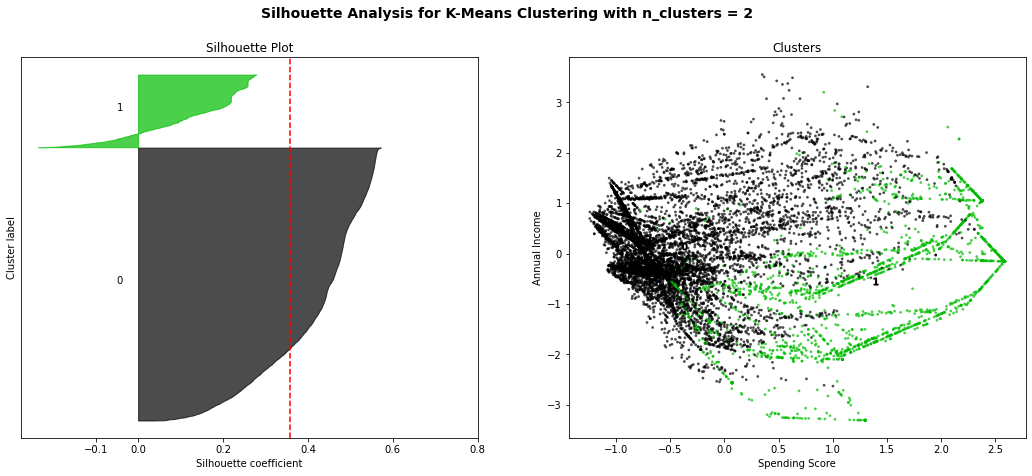

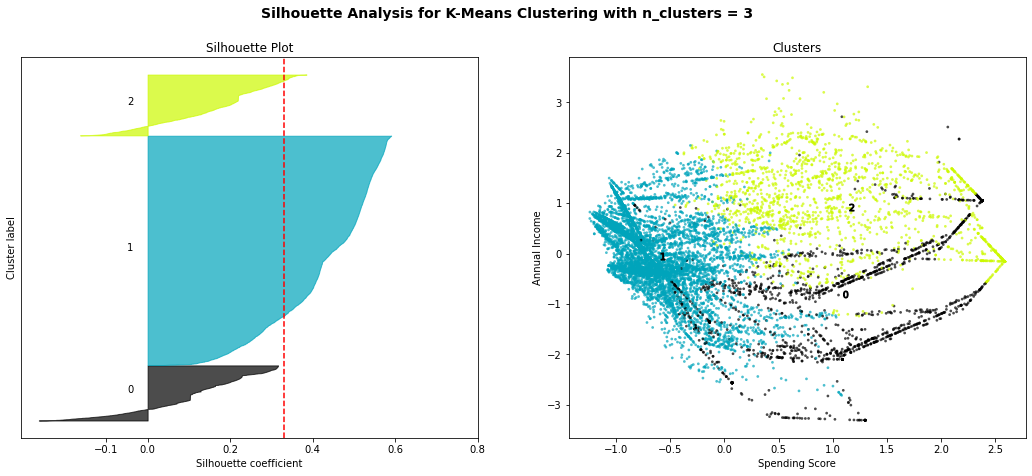

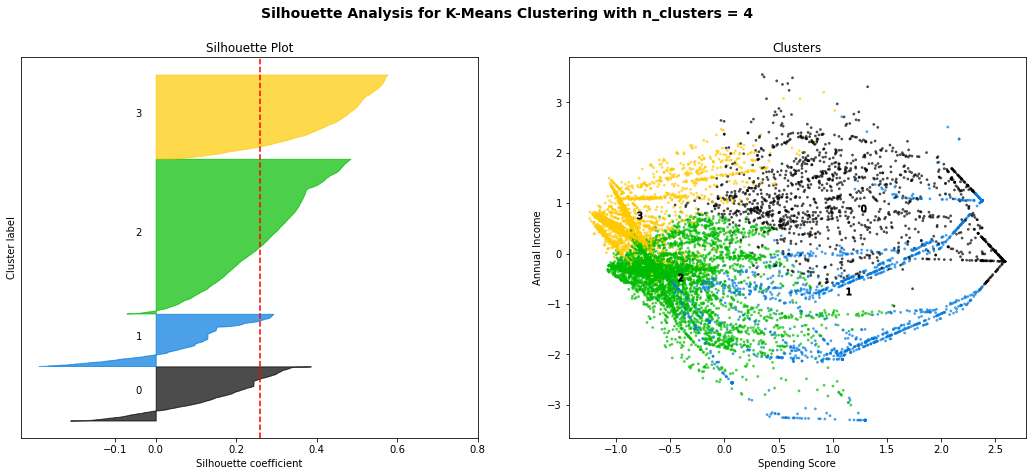

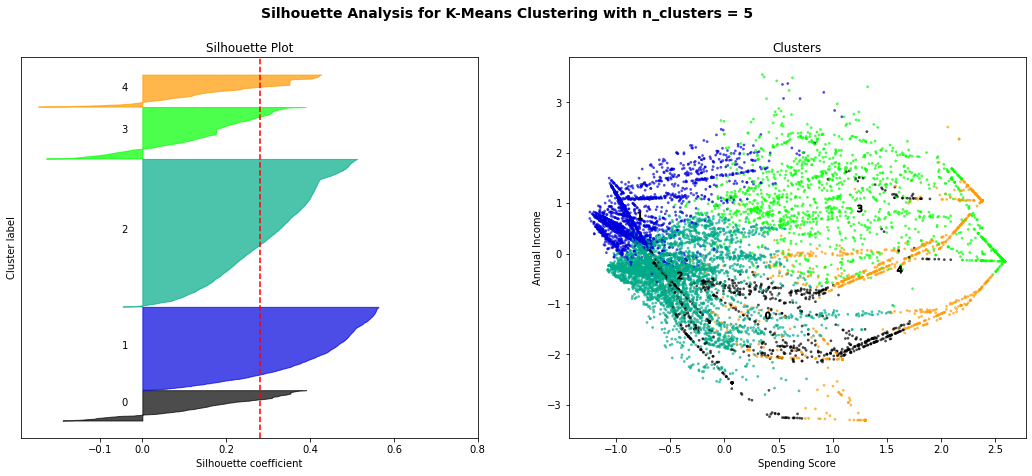

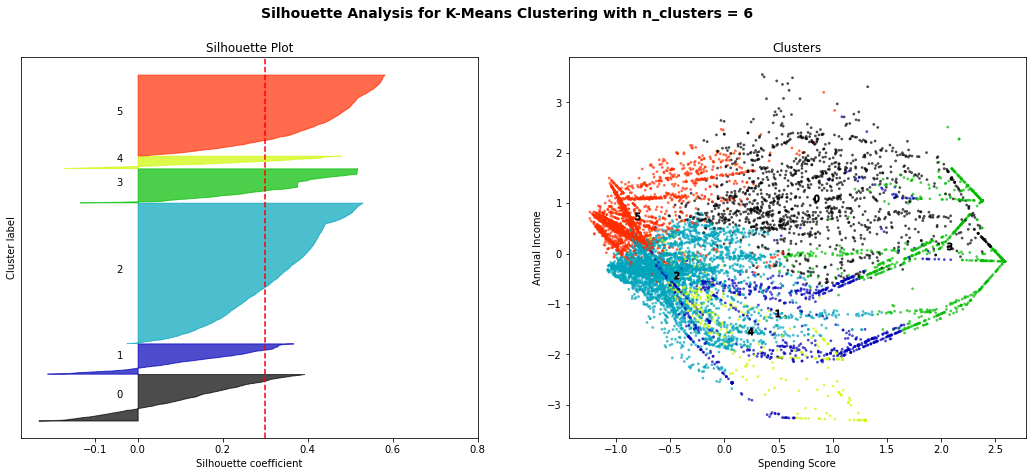

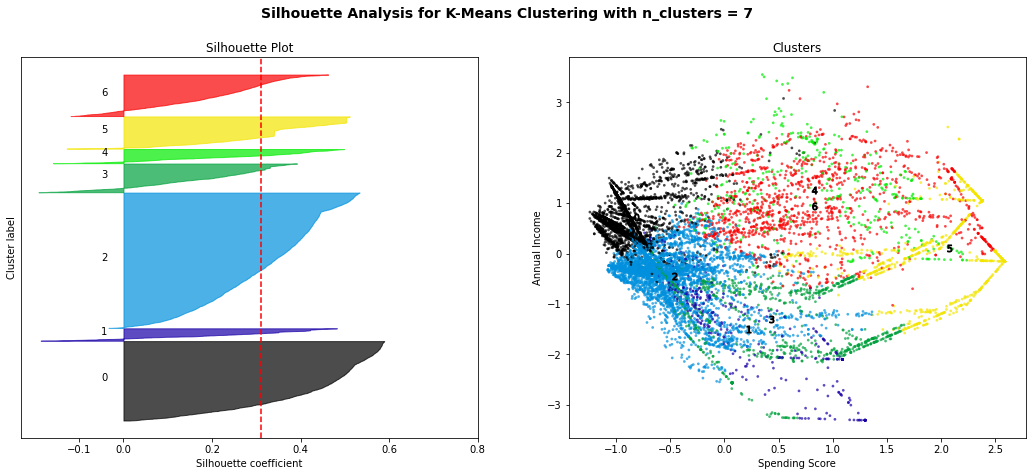

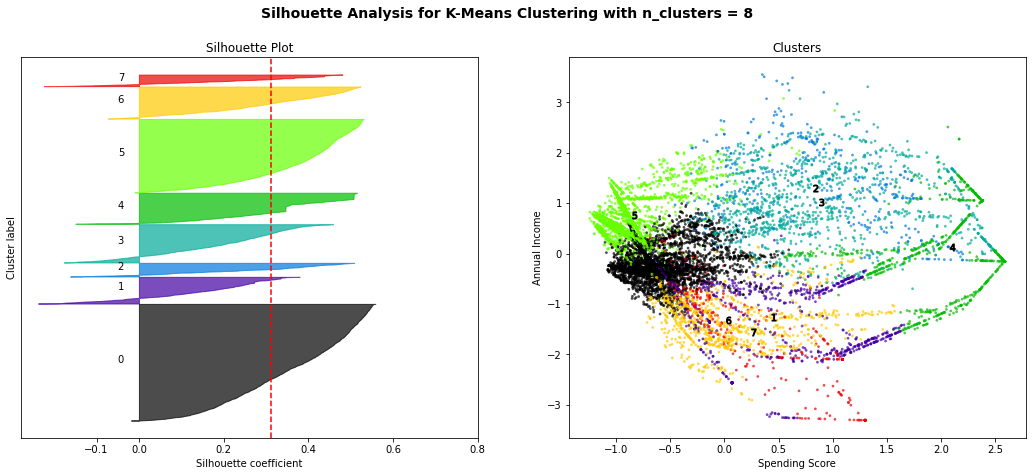

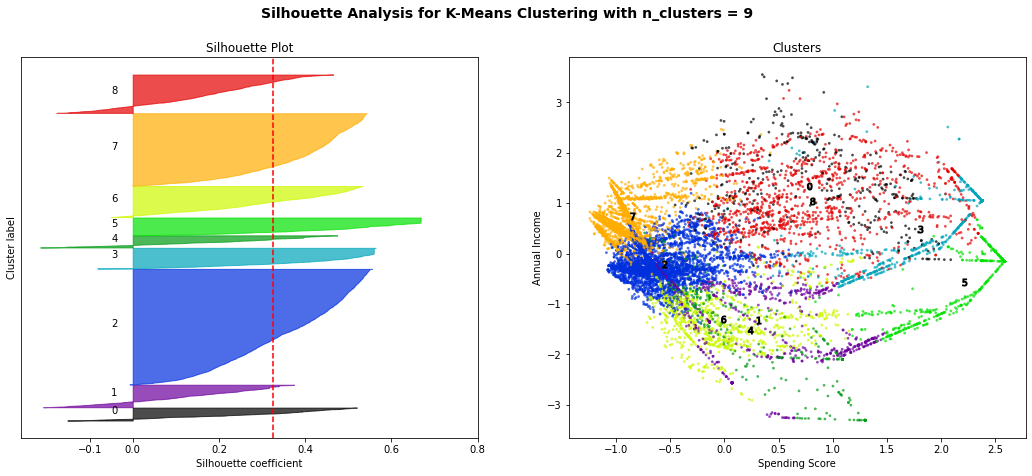

In [56]:
X = np.array(X)

# for each value of K, plot the silhouette plot the clusters formed
for K in n_clusters:
    
    # create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # set the figure size
    fig.set_size_inches(18, 7)

    # the 1st subplot is the silhouette plot
    # initialize the cluster with 'K' value and a random generator
    model = KMeans(n_clusters = K, random_state = 10)
    
    # fit and predict on the scaled data
    cluster_labels = model.fit_predict(X)

    # the 'silhouette_score()' gives the average value for all the samples
    silhouette_avg = silhouette_score(X, cluster_labels)
    
    # Compute the silhouette coefficient for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        
        # aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        
        # sort the silhouette coefficient
        ith_cluster_silhouette_values.sort()
        
        # calculate the size of the cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # color each cluster 
        color = cm.nipy_spectral(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # compute the new y_lower for next plot
        y_lower = y_upper + 10 

    # set the axes and plot label
    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette coefficient")
    ax1.set_ylabel("Cluster label")

    # plot the vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    # clear the y-axis ticks
    ax1.set_yticks([])  
    
    # set the ticks for x-axis 
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8])

    
    # 2nd plot showing the actual clusters formed
    # consider different color for each cluster
    colors = cm.nipy_spectral(cluster_labels.astype(float) / K)
    
    # plot a scatter plot to visualize the clusters
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # label the cluster centers
    centers = model.cluster_centers_
    
    # display the cluster center with cluster number
    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    # add the axes and plot title
    ax2.set_title("Clusters")
    ax2.set_xlabel("Spending Score")
    ax2.set_ylabel("Annual Income")
    
    # set the common title for subplots
    plt.suptitle(("Silhouette Analysis for K-Means Clustering with n_clusters = %d" % K), fontsize=14, 
                 fontweight='bold')

# display the plot
plt.show()

In [57]:
model = DBSCAN(eps=0.8, min_samples=15)

# fit the model on the scaled data
model.fit(df_pca)

DBSCAN(eps=0.8, min_samples=15)

In [58]:
set(model.labels_)

{-1, 0, 1, 2, 3, 4, 5}

In [59]:
df_prod = df_pca.copy()
# add a column containing cluster number to the original data
df_prod['Cluster_DBSCAN'] = model.labels_

# print head() of the newly formed dataframe
df_prod.head()

,PCA1,PCA2,PCA3,PCA4,Cluster_DBSCAN
0,-0.577322,-0.100142,-0.150288,-0.699199,0
1,-0.354880,-0.921005,-0.656367,-0.451197,0
2,1.179032,-1.502409,-0.215135,-0.315527,0
3,2.333253,0.670653,-0.122053,-1.083286,0
4,1.024836,-0.468322,1.519216,1.280206,0


In [60]:
df_prod['Cluster_DBSCAN'].value_counts()

 0    9566
-1      77
 3      45
 1      35
 4      31
 2      30
 5      29
Name: Cluster_DBSCAN, dtype: int64

Text(0, 0.5, 'No. of Products')

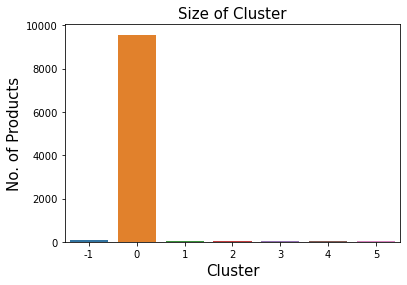

In [61]:
# plot the countplot for the cluster size
sns.countplot(data=df_prod, x='Cluster_DBSCAN')

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Size of Cluster', fontsize = 15)
plt.xlabel('Cluster', fontsize = 15)
plt.ylabel('No. of Products', fontsize = 15)

# display the plotplt.show()

In [62]:
def customGrid(eps_range, min_sample_range):
    scores = {}
    for eps in eps_range:
        print("\nFor eps = ", eps)
        int_scores = {"min_samples": [], "scores": [], "neg_count": [], "clusters": []}
        for min_samples in min_sample_range:
            model = DBSCAN(eps=eps, min_samples=min_samples)
            model.fit(df_pca)
            df_prod = df_pca.copy()
            df_prod['Cluster_DBSCAN'] = model.labels_
            value_counts = df_prod['Cluster_DBSCAN'].value_counts()
            neg_count = 0
            try:
                neg_count = value_counts[-1]
            except KeyError:
                pass
            
            int_scores["neg_count"].append(neg_count)
            
            
            df_prod1 = df_prod[df_prod['Cluster_DBSCAN'] != -1]
            clusters = df_prod1.Cluster_DBSCAN.nunique()
            int_scores["clusters"].append(clusters)
            if clusters > 1:
                score = silhouette_score(
                    df_prod1.drop(['Cluster_DBSCAN'], axis=1),
                    df_prod1.Cluster_DBSCAN,
                    random_state=10
                )
            else:
                score = -100

            scores[(eps, min_samples)] = {"score": score, "clusters": clusters, "outliers": neg_count}
            int_scores["min_samples"].append(min_samples)
            int_scores["scores"].append(round(score, 4))
                
        print(int_scores)
        if all(map(lambda x: x == -100, int_scores['scores'])):
            print("All the scores are below cuttoff -100 so stopping")
            break

    scores_list = [(k, v) for k, v in scores.items()]
    scores_list.sort(key=lambda x: x[1]["score"], reverse=True)
    print(scores_list[:10])
    top_score = scores_list[0]
    print("The best params is = ", top_score)
        

In [76]:
customGrid(np.arange(0.2, 5, 0.2), range(4, 20, 4))


For eps =  0.2
{'min_samples': [4, 8, 12, 16], 'scores': [-0.33, -0.1949, -0.0598, 0.1316], 'neg_count': [998, 1957, 2748, 3311], 'clusters': [127, 55, 52, 37]}

For eps =  0.4
{'min_samples': [4, 8, 12, 16], 'scores': [-0.1979, -0.087, -0.08, -0.1108], 'neg_count': [174, 448, 657, 934], 'clusters': [30, 14, 15, 13]}

For eps =  0.6000000000000001
{'min_samples': [4, 8, 12, 16], 'scores': [0.1613, 0.0872, 0.2439, 0.2827], 'neg_count': [57, 105, 201, 311], 'clusters': [5, 7, 12, 8]}

For eps =  0.8
{'min_samples': [4, 8, 12, 16], 'scores': [0.3924, -100, 0.3479, 0.3339], 'neg_count': [27, 40, 66, 95], 'clusters': [3, 1, 3, 6]}

For eps =  1.0
{'min_samples': [4, 8, 12, 16], 'scores': [0.391, -100, -100, -100], 'neg_count': [17, 30, 30, 35], 'clusters': [3, 1, 1, 1]}

For eps =  1.2
{'min_samples': [4, 8, 12, 16], 'scores': [0.3867, -100, -100, -100], 'neg_count': [10, 25, 26, 27], 'clusters': [3, 1, 1, 1]}

For eps =  1.4000000000000001
{'min_samples': [4, 8, 12, 16], 'scores': [0.4522

In [83]:
customGrid(np.arange(0.6, 1.9, 0.1), range(4, 12, 2))


For eps =  0.6
{'min_samples': [4, 6, 8, 10], 'scores': [0.1613, 0.1073, 0.0872, 0.2528], 'neg_count': [57, 86, 105, 144], 'clusters': [5, 4, 7, 9]}

For eps =  0.7
{'min_samples': [4, 6, 8, 10], 'scores': [0.427, -100, 0.4645, 0.3579], 'neg_count': [36, 50, 55, 78], 'clusters': [2, 1, 2, 4]}

For eps =  0.7999999999999999
{'min_samples': [4, 6, 8, 10], 'scores': [0.3924, 0.4247, -100, -100], 'neg_count': [27, 31, 40, 48], 'clusters': [3, 2, 1, 1]}

For eps =  0.8999999999999999
{'min_samples': [4, 6, 8, 10], 'scores': [0.3913, 0.4245, -100, -100], 'neg_count': [21, 29, 36, 36], 'clusters': [3, 2, 1, 1]}

For eps =  0.9999999999999999
{'min_samples': [4, 6, 8, 10], 'scores': [0.391, 0.424, -100, -100], 'neg_count': [17, 23, 30, 30], 'clusters': [3, 2, 1, 1]}

For eps =  1.0999999999999999
{'min_samples': [4, 6, 8, 10], 'scores': [0.3907, 0.4237, -100, -100], 'neg_count': [14, 19, 25, 27], 'clusters': [3, 2, 1, 1]}

For eps =  1.1999999999999997
{'min_samples': [4, 6, 8, 10], 'scores':

In [82]:
customGrid(np.arange(0.7, 1.5, 0.1), range(4, 9, 2))


For eps =  0.7
{'min_samples': [4, 6, 8], 'scores': [0.427, -100, 0.4645], 'neg_count': [36, 50, 55], 'clusters': [2, 1, 2]}

For eps =  0.7999999999999999
{'min_samples': [4, 6, 8], 'scores': [0.3924, 0.4247, -100], 'neg_count': [27, 31, 40], 'clusters': [3, 2, 1]}

For eps =  0.8999999999999999
{'min_samples': [4, 6, 8], 'scores': [0.3913, 0.4245, -100], 'neg_count': [21, 29, 36], 'clusters': [3, 2, 1]}

For eps =  0.9999999999999999
{'min_samples': [4, 6, 8], 'scores': [0.391, 0.424, -100], 'neg_count': [17, 23, 30], 'clusters': [3, 2, 1]}

For eps =  1.0999999999999999
{'min_samples': [4, 6, 8], 'scores': [0.3907, 0.4237, -100], 'neg_count': [14, 19, 25], 'clusters': [3, 2, 1]}

For eps =  1.1999999999999997
{'min_samples': [4, 6, 8], 'scores': [0.3867, 0.3871, -100], 'neg_count': [10, 13, 25], 'clusters': [3, 3, 1]}

For eps =  1.2999999999999998
{'min_samples': [4, 6, 8], 'scores': [0.3865, 0.3871, -100], 'neg_count': [8, 13, 25], 'clusters': [3, 3, 1]}

For eps =  1.4
{'min_sam

In [ ]:
# min_count = 8, eps = 0.7

In [85]:
model = DBSCAN(eps=0.7, min_samples=8)
model.fit(df_pca)
df_prod = df_pca.copy()
score = silhouette_score(df_pca, model.labels_, random_state=10)
print(score)
df_prod['Cluster_DBSCAN'] = model.labels_
df_prod['Cluster_DBSCAN'].value_counts()

0.39828625271035817


 0    9682
 1      76
-1      55
Name: Cluster_DBSCAN, dtype: int64

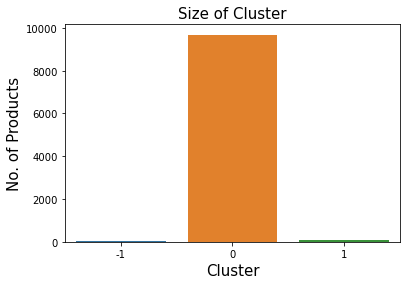

In [86]:
# plot the countplot for the cluster size
sns.countplot(data=df_prod, x='Cluster_DBSCAN')

# set the axes and plot labels
# set the font size using 'fontsize'
plt.title('Size of Cluster', fontsize = 15)
plt.xlabel('Cluster', fontsize = 15)
plt.ylabel('No. of Products', fontsize = 15)

# display the plot
plt.show()

In [87]:
# create a list for different values of K
n_clusters = list(range(2, 10))

# use 'for' loop to build the clusters
# 'random_state' returns the same sample each time you run the code  
# fit and predict on the scaled data
# 'silhouette_score' function computes the silhouette score for each K
for K in n_clusters:
    cluster = AgglomerativeClustering(n_clusters=K)
    predict = cluster.fit_predict(X)
    score = silhouette_score(X, predict, random_state= 10)
    print ("For {} clusters the silhouette score is {})".format(K, score))

For 2 clusters the silhouette score is 0.34495027107610826)
For 3 clusters the silhouette score is 0.20043820520659686)
For 4 clusters the silhouette score is 0.20274386393141833)
For 5 clusters the silhouette score is 0.23103775937407775)
For 6 clusters the silhouette score is 0.24687665251187704)
For 7 clusters the silhouette score is 0.25781084704171436)
For 8 clusters the silhouette score is 0.2696762608320779)
For 9 clusters the silhouette score is 0.2736376635215206)
